![Toronto 311 Logo](https://pbs.twimg.com/media/Cp7-NNBWAAAWy8L.jpg "Toronto 311 Logo")

# The non-emergencies of Toronto <a name="TOC"></a>
### <i>A study of over 350,000 customer initiated 311 service requests received in 2020</i>
<br>

1. [Introduction](#introduction)
2. [311 Service Request Exploration](#311-data)<br>
    a) [Request Status](#status) <br>
    b) [Request Type](#type) <br>
    c) [Division](#division) <br>
    d) [Section](#section) <br>
    e) [Date & Time](#date-time) <br>
    f) [Location: FSAs, Intersections & Wards](#location) <br>
4. [Ward Profiles Exploration](#wards)<br>
5. [Weather Data Exploration](#weather)<br>
6. [Classification Modeling: 311 Request Section Prediction](#model)<br>
7. [Conclusion](#conclusion)

## Introduction <a name="introduction"></a>

The main dataset we’re using is provided by 311 Toronto (via the City of Toronto's Open Data Portal), viewable <a href="https://open.toronto.ca/dataset/311-service-requests-customer-initiated/">here</a>. 311 operates 24/7 and manages City divisional service request data for Solid Waste Management, Transportation Services, Toronto Water, Municipal Licensing & Standards, and Urban Forestry. 

We will be using the 2020 data, which contains almost 350,000 customer initiated service requests, collected from multiple channels including telephone, fax, email, online self-serve requests, mobile API and Twitter. Note that all service requests represent 30 - 35% of all contact with 311 (and this dataset is a subset of this 30 - 35%).

We will also be using <a href="https://open.toronto.ca/dataset/ward-profiles-2018-25-ward-model/">Toronto Ward Profiles</a> (via Toronto's Open Data Portal, based on Statistics Canada's 2016 Census) and 
<a href="https://climate.weather.gc.ca/climate_data/daily_data_e.html?hlyRange=2013-06-11%7C2021-12-04&dlyRange=2013-06-13%7C2021-12-04&mlyRange=%7C&StationID=51459&Prov=ON&urlExtension=_e.html&searchType=stnProx&optLimit=specDate&Month=1&Day=1&StartYear=1840&EndYear=2016&Year=2020&selRowPerPage=25&Line=4&txtRadius=25&optProxType=navLink&txtLatDecDeg=43.666666666667&txtLongDecDeg=-79.4&timeframe=2">Toronto weather data</a> 
(via the Government of Canada's Historical Weather Data Portal) to spice up our analysis.

<b>As a long-time resident of Toronto, I have never personally contacted 311. I'm curious as to:</b>

* What area of Toronto makes the most service requests, and what are they about?
* Can we predict what a Torontonian is likely to be contacting 311 about based on their address, time of year, time of day, weather, or other factors?

<b>[TLDR] To see this analysis visualized, view the Tableau exploration: 
    https://public.tableau.com/app/profile/meaghan.barry/viz/311_16389979943830/Overview </b>
    
<i>Note: When you see this blue arrow ( [↑](#TOC) ) click it to return to the main TOC. </i>

In [1]:
# import libraries 
import numpy as np
import pandas as pd
import statistics as st
import seaborn as sns
from datetime import date

# import models
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# import evaluation functions
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score

# matplotlib for plotting modification
import matplotlib.pyplot as plt
%matplotlib inline

# scikitplot to directly plot our results
import graphviz
import scikitplot as skplt
from mlxtend.plotting import plot_decision_regions
from mlxtend.plotting import category_scatter 

# other imports
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

In [2]:
# import data
requests_2020 = pd.read_csv('SR2020.csv')
weather_2020 = pd.read_csv('en_climate_daily_ON_6158731_2020_P1D.csv')
ward_profiles = pd.read_csv('ward_profiles.csv')

[↑ Back to TOC](#TOC)
## 311 Service Requests <a name="311-data"></a> 
This main dataset includes almost 350,000 requests, with a variety of data to explore. 

In [3]:
requests_2020.head()

,Creation Date,Status,First 3 Chars of Postal Code,Intersection Street 1,Intersection Street 2,Ward,Service Request Type,Division,Section
0,2020-01-01 00:01:46.0000000,Closed,Intersection,Chaplin Cres,Davisville Ave,Toronto-St. Paul's (12),INJUR/DIST DOMESTIC,Municipal Licensing & Standards,Toronto Animal Services
1,2020-01-01 01:36:56.0000000,Closed,M4C,NaN,NaN,Beaches-East York (19),Sewer Service Line-Blocked,Toronto Water,District Ops
2,2020-01-01 02:42:16.0000000,Closed,M9A,NaN,NaN,Etobicoke-Lakeshore (03),ENF/INVEST MUZZLE,Municipal Licensing & Standards,Toronto Animal Services
3,2020-01-01 02:52:29.0000000,Closed,M6C,NaN,NaN,Toronto-St. Paul's (12),Hydrant-Damage,Toronto Water,District Ops
4,2020-01-01 02:56:34.0000000,Closed,Intersection,Don Mills Rd,Sheppard Ave E,Don Valley North (17),Traffic Signal Maintenance,Transportation Services,TMC


In [4]:
total_requests_2020 = requests_2020.shape[0]
total_requests_2020

347748

### [↑](#TOC) Request Status <a name="status"></a> 
Statuses are as of midnight, Dec 31st, 2020.

In [5]:
requests_2020['Status'].unique()
# viewing the status options, noticing there are two 'In-Progress' values

array(['Closed', 'Cancelled', 'In-progress ', 'Initiated', 'In-Progress'],
      dtype=object)

In [6]:
# cleaning in-progress values: removing white space & capitalizing P
requests_2020['Status'] = requests_2020['Status'].replace('In-progress ', 'In-Progress')

In [7]:
requests_2020.groupby('Status').size().sort_values(ascending=False)

Status
Closed         293270
Cancelled       46353
In-Progress      5414
Initiated        2711
dtype: int64

In [8]:
closed_status = requests_2020.groupby('Status').size().sort_values(ascending=False)[0]
cancelled_status = requests_2020.groupby('Status').size().sort_values(ascending=False)[1]

In [9]:
print(f'By the end of the year, the majority of service requests ({round(closed_status/total_requests_2020*100,2)}%) were closed, and {round(cancelled_status/total_requests_2020*100,2)}% had been cancelled.')

By the end of the year, the majority of service requests (84.33%) were closed, and 13.33% had been cancelled.


<AxesSubplot:ylabel='Request Status'>

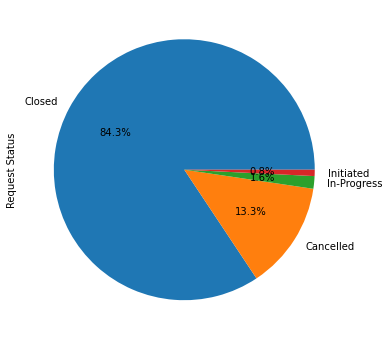

In [10]:
plt.figure(figsize=(18,6))
requests_2020.groupby('Status').size().sort_values(ascending=False).plot(kind='pie', ylabel='Request Status', autopct='%1.1f%%')

### [↑](#TOC) Request Type <a name="type"></a> 
Originally, I wanted to look into request types (I thought the more granular the better!) but upon closer look we see that there are almost 500 different types – and the string values were entered very inconsistently:

In [11]:
# finding the amount of unique request types
requests_2020['Service Request Type'].unique().shape[0]

486

In [12]:
# we see that the type values are not formatted consistently (e.g. "Res /" vs. "Residential:")
requests_2020['Service Request Type'].unique()

array(['INJUR/DIST DOMESTIC', 'Sewer Service Line-Blocked',
       'ENF/INVEST MUZZLE', 'Hydrant-Damage',
       'Traffic Signal Maintenance', 'Road-Illegal Dumping',
       'Res / Garbage / Not Picked Up',
       'Boulevard - Leaf Pick-up Mechanical',
       'Road - Sanding / Salting Required',
       'All / Hazardous Waste / Pick Up Request',
       'FEL Multi-Res Furniture / Not Picked Up',
       'Road - Cleaning/Debris', 'Property Standards',
       'Non-Res Organic Bin / Not Picked Up',
       'Res / Nite Organic / Not Picked Up', 'Road - Pot hole',
       'Water Service Line-No Water',
       'Residential Furniture / Not Picked Up',
       'Res / Org&Recycle Multiple Addresses / Not Picked Up',
       'Residential: Garbage Bin: Exchange to Large', 'CADAVER DOMESTIC',
       'Res / Organic Green Bin / Multiple Addresses / Not Picked Up',
       'INJUR/DIST WILDLIFE', 'Missing/Damaged Signs',
       'Missing/Faded Pavement Markings', 'SERVICES RABIES SUS',
       'Non-Res Garbage 

In [13]:
service_request_types = requests_2020.groupby('Service Request Type').size().sort_values(ascending=False)

In [14]:
# Note: Due to inconsistent formatting of type values, this list is likely not fully accurate
# Quick look at the ten most popular service request types
service_request_types.head(10)

Service Request Type
INJUR/DIST WILDLIFE                                18448
Residential: Bin: Repair or Replace Lid            16620
CADAVER WILDLIFE                                   12000
General Pruning                                    10652
Property Standards                                  9684
Res / Garbage / Not Picked Up                       8373
Residential Furniture / Not Picked Up               8207
All / Hazardous Waste / Pick Up Request             8155
Road - Pot hole                                     8070
Residential: Bin: Repair or Replace Body/Handle     7455
dtype: int64

In [15]:
# Note: Due to inconsistent formatting of type values, this list is likely not fully accurate
# Quick look at the 10 rarest service request types (aka types with only one instance)
service_request_types.sort_values(ascending=True).head(16)

Service Request Type
SERVICES RABIES SUS                                          1
Planting 11 Plus Trees FNEM                                  1
Pedestrian Refuge Island                                     1
West Nile Virus-Standing Water / Roadside                    1
West Nile Virus - Standing Water / Roadway                   1
Res / Nite Org&Garbage Multiple Addresses / Not Picked Up    1
Multi-Res / Ewaste / Not Picked Up                           1
Watercraft                                                   1
Taxicab Stand                                                1
Publication Request - Other                                  1
School Bus Loading Zone                                      1
Property Damaged/Litter Operations                           1
Trades Complaint                                             1
Non-Res XMAS Tree Nite / Not Picked Up                       1
Hydrant-Request for Usage                                    1
Graffiti on Hydro Asset           

Since the request type values were quite messy, let's take a look at the divisions and services features.

### [↑](#TOC) Division <a name="division"></a> 
Represents the responsible 311 Integrated Service Division for each request. It corresponds to the original service request type, regardless of subsequent service request type changes by the back-end divisions.

In [16]:
requests_2020['Division'].unique().shape[0]

7

In [17]:
requests_2020['Division'].unique()

array(['Municipal Licensing & Standards', 'Toronto Water',
       'Transportation Services', 'Solid Waste Management Services',
       'Urban Forestry', '311', 'City of Toronto'], dtype=object)

In [18]:
requests_2020.groupby('Division').size().sort_values(ascending=False)

Division
Solid Waste Management Services    146892
Municipal Licensing & Standards     69576
Transportation Services             63932
Toronto Water                       33309
Urban Forestry                      28628
311                                  5317
City of Toronto                        94
dtype: int64

<AxesSubplot:ylabel='Division'>

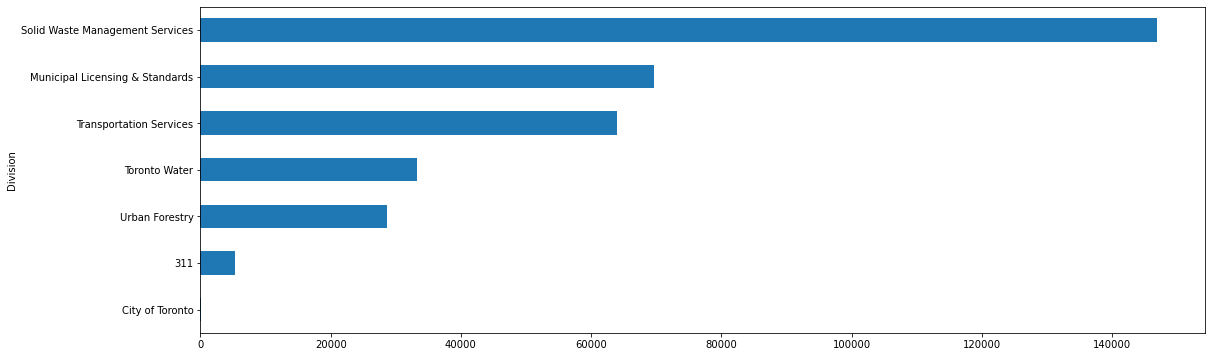

In [19]:
plt.figure(figsize=(18,6))
requests_2020.groupby('Division').size().sort_values(ascending=True).plot(kind='barh')

This data is well formatted, but unfortunately is too aggregated (mainly in five divisions) to provide us with interesting insights. 

### [↑](#TOC) Section <a name="section"></a> 
Represents the specific section / unit, which are smaller subsets of the divisions explored above.

In [20]:
requests_2020['Section'].unique().shape[0]

20

In [21]:
requests_2020['Section'].unique()

array(['Toronto Animal Services', 'District Ops', 'TMC',
       'Road Operations', 'Collections', 'District Enforcement',
       'Right of Way (ROW)', 'Parks Enforcement', 'Waste Enforcement',
       'Forestry Operations', 'Tree Protection and Plan Review',
       'Operations', 'Traffic Ops', 'Litter Operations',
       'Business Operations Management', 'All City Divisions',
       'Traffic Safety', 'Businesss Licensing Enforcement',
       'Forestry and Natural Environment Management',
       'Transfer, Disposal & Operations'], dtype=object)

In [22]:
requests_by_section = pd.DataFrame(requests_2020.groupby('Section').size().sort_values(ascending=False), columns=['Request_Count'])
requests_by_section.reset_index().head()

,Section,Request_Count
0,Collections,145689
1,Road Operations,45904
2,Toronto Animal Services,38479
3,District Ops,32752
4,Forestry Operations,25213


In [23]:
requests_by_section['% of Total'] = round(requests_by_section['Request_Count'] / total_requests_2020*100, 2)

In [24]:
requests_by_section

,Request_Count,% of Total
Section,,
Collections,145689,41.89
Road Operations,45904,13.20
Toronto Animal Services,38479,11.07
District Ops,32752,9.42
Forestry Operations,25213,7.25
District Enforcement,23319,6.71
TMC,9831,2.83
Right of Way (ROW),5493,1.58
Operations,5317,1.53


<AxesSubplot:ylabel='Section'>

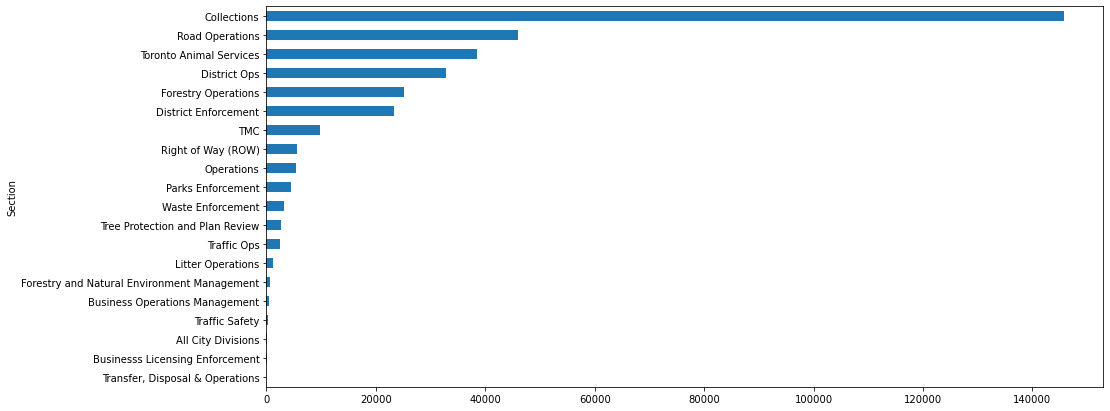

In [25]:
# plotting count of requests by section
plt.figure(figsize=(15,7))
requests_by_section['Request_Count'].sort_values(ascending=True).plot(kind='barh')

By far, the most frequent division section is Collections – making up 42% of the total requests (145,689 out of 347,748). Let's quickly take a look at what types of requests are being serviced by the Collections Department Section.

In [26]:
collections_requests = requests_2020[requests_2020['Section'] == 'Collections'].copy()
collections_requests.groupby('Division').size()

Division
Solid Waste Management Services    145689
dtype: int64

In [27]:
collections_requests.groupby('Service Request Type').size().sort_values(ascending=False)

Service Request Type
Residential: Bin: Repair or Replace Lid                      16620
Res / Garbage / Not Picked Up                                 8373
Residential Furniture / Not Picked Up                         8207
All / Hazardous Waste / Pick Up Request                       8155
Residential: Bin: Repair or Replace Body/Handle               7455
                                                             ...  
FEL Non-Res Xmas Tree / Not Picked Up                            2
Property Damaged/Litter Operations                               1
Non-Res XMAS Tree Nite / Not Picked Up                           1
Multi-Res / Ewaste / Not Picked Up                               1
Res / Nite Org&Garbage Multiple Addresses / Not Picked Up        1
Length: 176, dtype: int64

So many broken residential bins!

This section data is clean and a good size for our analysis (20 total), so we will use the sections moving forward as our "type" of service request. 

### [↑](#TOC) Date + Time <a name="date-time"></a> 
We have been provided with a detailed time for the request creation, which we will extract for our analysis. 

In [28]:
# Current date/time format
requests_2020['Creation Date'][0]

'2020-01-01 00:01:46.0000000'

In [29]:
# converting 'Creation Date' column to datetime format, extracting date and converting to seperate column
requests_2020['Date'] = pd.to_datetime(pd.to_datetime(requests_2020['Creation Date']).dt.date)

# converting 'Creation Date' column to datetime format, extracting date and converting to seperate column
requests_2020['Time'] = (pd.to_datetime(requests_2020['Creation Date']).dt.time)

# extract the hour from 'Creation Date' column - to analyse without minute or second data
requests_2020['Hour'] = pd.to_datetime(requests_2020['Creation Date']).dt.hour

# drop full 'Creation Date' column
requests_2020.drop(columns ='Creation Date', inplace=True)

In [30]:
requests_2020.head()

,Status,First 3 Chars of Postal Code,Intersection Street 1,Intersection Street 2,Ward,Service Request Type,Division,Section,Date,Time,Hour
0,Closed,Intersection,Chaplin Cres,Davisville Ave,Toronto-St. Paul's (12),INJUR/DIST DOMESTIC,Municipal Licensing & Standards,Toronto Animal Services,2020-01-01,00:01:46,0
1,Closed,M4C,NaN,NaN,Beaches-East York (19),Sewer Service Line-Blocked,Toronto Water,District Ops,2020-01-01,01:36:56,1
2,Closed,M9A,NaN,NaN,Etobicoke-Lakeshore (03),ENF/INVEST MUZZLE,Municipal Licensing & Standards,Toronto Animal Services,2020-01-01,02:42:16,2
3,Closed,M6C,NaN,NaN,Toronto-St. Paul's (12),Hydrant-Damage,Toronto Water,District Ops,2020-01-01,02:52:29,2
4,Closed,Intersection,Don Mills Rd,Sheppard Ave E,Don Valley North (17),Traffic Signal Maintenance,Transportation Services,TMC,2020-01-01,02:56:34,2


In [31]:
# formatting data to plot in Seaborn
requests_2020_by_day = requests_2020.groupby('Date').size()
requests_2020_by_day = pd.DataFrame(requests_2020_by_day, columns=['Requests']).reset_index()

In [32]:
requests_2020_by_day.head()

,Date,Requests
0,2020-01-01,333
1,2020-01-02,1046
2,2020-01-03,1129
3,2020-01-04,598
4,2020-01-05,414


<AxesSubplot:xlabel='Date', ylabel='Requests'>

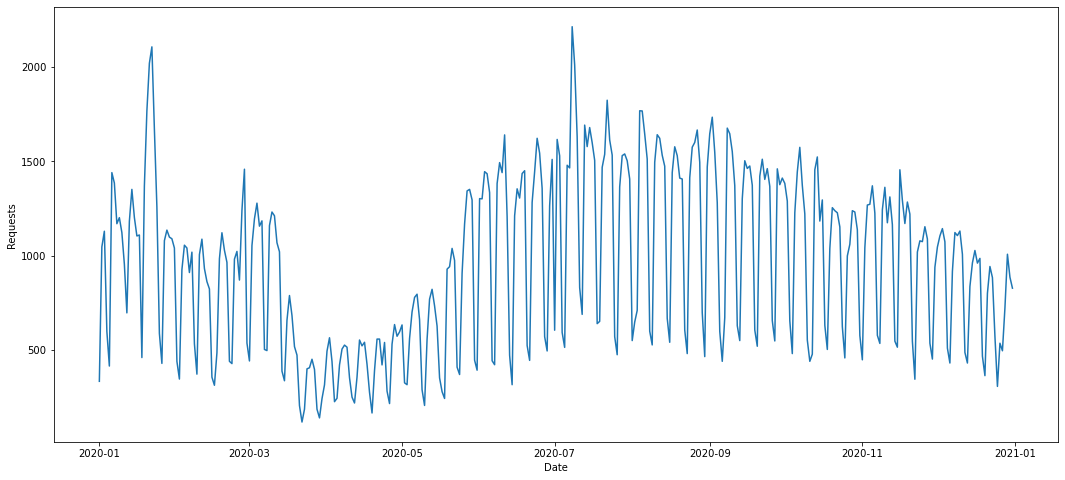

In [33]:
plt.figure(figsize=(18,8))
sns.lineplot(data=requests_2020_by_day, x="Date", y="Requests")

We see fairly consistent peaks and valleys throughout the year. Let's take a look at one month. 

In [34]:
# filtering data to just look at January
requests_jan_2020 = requests_2020[requests_2020['Date'].dt.month == 1].groupby('Date').size()
requests_jan_2020 = pd.DataFrame(requests_jan_2020, columns=['Requests'])

<AxesSubplot:xlabel='Date', ylabel='Requests'>

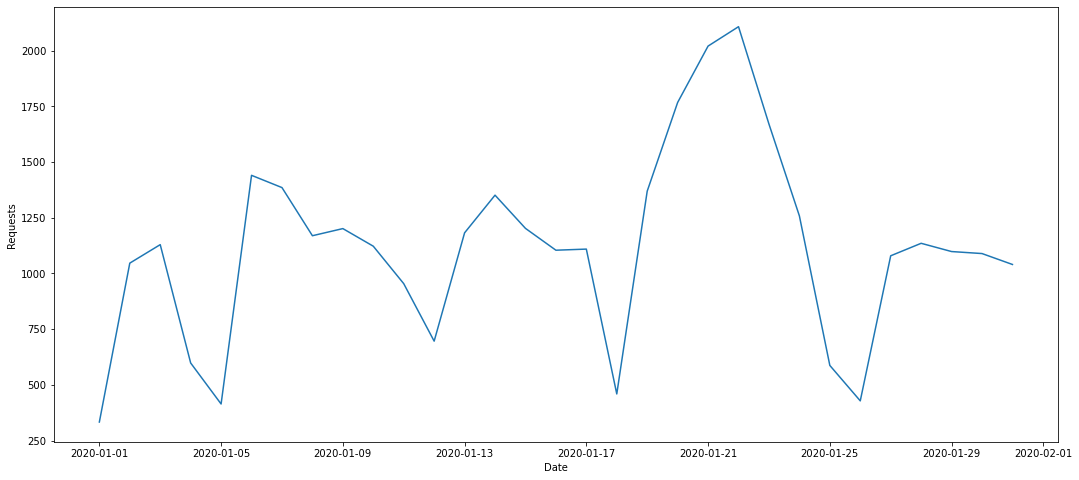

In [35]:
plt.figure(figsize=(18,8))
sns.lineplot(data=requests_jan_2020, x='Date', y='Requests')

We're now seeing four distinct request dips in January – my guess is that this is due to the effect of weekends. Let's engineer some new features = day of week and weekend:

In [36]:
# create day of week column
requests_2020['Day of Week'] = requests_2020['Date'].dt.day_name()

In [37]:
# create weekend column: 1 = day is on a weekend, 0 = day is not on a weekend
requests_2020['Weekend'] = np.where(requests_2020['Day of Week'].isin(['Saturday', 'Sunday']), 1, 0)

In [38]:
requests_2020.head(1)

,Status,First 3 Chars of Postal Code,Intersection Street 1,Intersection Street 2,Ward,Service Request Type,Division,Section,Date,Time,Hour,Day of Week,Weekend
0,Closed,Intersection,Chaplin Cres,Davisville Ave,Toronto-St. Paul's (12),INJUR/DIST DOMESTIC,Municipal Licensing & Standards,Toronto Animal Services,2020-01-01,00:01:46,0,Wednesday,0


In [39]:
requests_2020.groupby('Day of Week').size().sort_values(ascending=False)

Day of Week
Wednesday    63114
Thursday     62720
Tuesday      62555
Friday       57322
Monday       52651
Saturday     26498
Sunday       22888
dtype: int64

<AxesSubplot:xlabel='Day of Week'>

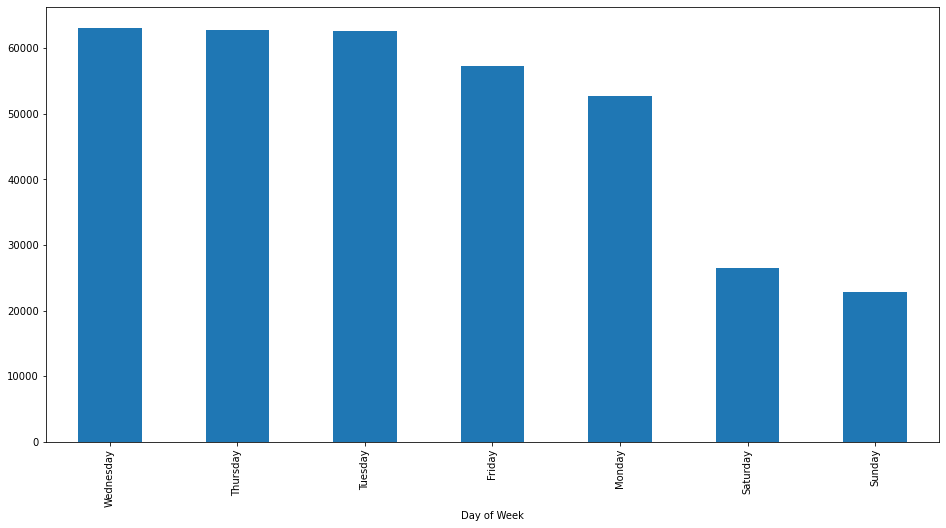

In [40]:
# plot the count of service requests recieved based on day of week 

plt.figure(figsize=(16,8))
requests_2020.groupby('Day of Week').size().sort_values(ascending=False).plot(kind='bar')

### [↑](#TOC) Locations <a name="location"></a> 

#### Intersections vs. Postal Codes
We notice that some requests provide the first 3 digits of a postal code (AKA the forward sortation area / FSA) while others have the value "intersection" and two corresponding streets. Let's take a look at how many requests have an intersection value instead of a FSA, and how they are distributed, so we can sort out what to do with them.

In [41]:
requests_2020.head()

,Status,First 3 Chars of Postal Code,Intersection Street 1,Intersection Street 2,Ward,Service Request Type,Division,Section,Date,Time,Hour,Day of Week,Weekend
0,Closed,Intersection,Chaplin Cres,Davisville Ave,Toronto-St. Paul's (12),INJUR/DIST DOMESTIC,Municipal Licensing & Standards,Toronto Animal Services,2020-01-01,00:01:46,0,Wednesday,0
1,Closed,M4C,NaN,NaN,Beaches-East York (19),Sewer Service Line-Blocked,Toronto Water,District Ops,2020-01-01,01:36:56,1,Wednesday,0
2,Closed,M9A,NaN,NaN,Etobicoke-Lakeshore (03),ENF/INVEST MUZZLE,Municipal Licensing & Standards,Toronto Animal Services,2020-01-01,02:42:16,2,Wednesday,0
3,Closed,M6C,NaN,NaN,Toronto-St. Paul's (12),Hydrant-Damage,Toronto Water,District Ops,2020-01-01,02:52:29,2,Wednesday,0
4,Closed,Intersection,Don Mills Rd,Sheppard Ave E,Don Valley North (17),Traffic Signal Maintenance,Transportation Services,TMC,2020-01-01,02:56:34,2,Wednesday,0


First off, how many requests have an intersection value vs. postal code?

In [42]:
# creating a dataframe with just the intersection values
requests_2020_intersection = requests_2020[requests_2020['First 3 Chars of Postal Code'] == 'Intersection'].copy()

In [43]:
requests_2020_intersection.head()

,Status,First 3 Chars of Postal Code,Intersection Street 1,Intersection Street 2,Ward,Service Request Type,Division,Section,Date,Time,Hour,Day of Week,Weekend
0,Closed,Intersection,Chaplin Cres,Davisville Ave,Toronto-St. Paul's (12),INJUR/DIST DOMESTIC,Municipal Licensing & Standards,Toronto Animal Services,2020-01-01,00:01:46,0,Wednesday,0
4,Closed,Intersection,Don Mills Rd,Sheppard Ave E,Don Valley North (17),Traffic Signal Maintenance,Transportation Services,TMC,2020-01-01,02:56:34,2,Wednesday,0
8,Closed,Intersection,Kingston Rd,Galloway Rd,Scarborough-Guildwood (24),Road - Sanding / Salting Required,Transportation Services,Road Operations,2020-01-01,07:43:14,7,Wednesday,0
9,Closed,Intersection,Kingston Rd,Celeste Dr,Scarborough-Guildwood (24),Road - Sanding / Salting Required,Transportation Services,Road Operations,2020-01-01,07:49:22,7,Wednesday,0
13,Closed,Intersection,Starview Lane,Humber River Recreational Trl,Humber River-Black Creek (07),Traffic Signal Maintenance,Transportation Services,TMC,2020-01-01,08:18:46,8,Wednesday,0


In [44]:
print(f'Requests that list intersections as opposed to postal codes make up {round(requests_2020_intersection.shape[0] / total_requests_2020 * 100, 2)}% of the total requests:\n{requests_2020_intersection.shape[0]} of the total {total_requests_2020}.')

Requests that list intersections as opposed to postal codes make up 11.74% of the total requests:
40836 of the total 347748.


In [45]:
unique_intersections = requests_2020.groupby(['Intersection Street 1', 'Intersection Street 2']).size().sort_values(ascending=False)
unique_intersections

Intersection Street 1  Intersection Street 2
King St W              John St                  671
F G Gardiner Xy W      Jameson Ave               69
Don Mills Rd           Eglinton Ave E            67
Marine Parade Dr       Lake Shore Blvd W         61
Bathurst St            Wilson Ave                60
                                               ... 
Fort York Blvd         Angelique St               1
Fort Dearborn Dr       Perthshire St              1
Forsythia Dr           Lyncroft Dr                1
Forman Ave             Soudan Ave                 1
Gilmour Ave            Woodside Ave               1
Length: 9783, dtype: int64

In [46]:
print(f'Of the {requests_2020_intersection.shape[0]} requests that list intersections, only {unique_intersections.shape[0]} intersections are unique.')

Of the 40836 requests that list intersections, only 9783 intersections are unique.


<AxesSubplot:ylabel='Intersection Street 1,Intersection Street 2'>

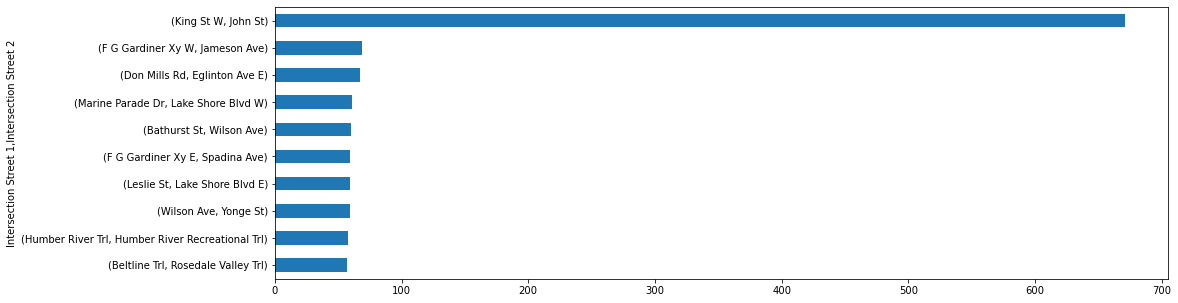

In [47]:
plt.figure(figsize=(16,5))
unique_intersections.head(10).sort_values(ascending=True).plot(kind='barh')

Interestingly, the intersection of King St. West and John St. is listed for 671 of the requests, far more than any other request. 

12% of the total values is quite large. Let's see how the requests with intersection data are distributed compared to all the data, by Section and Ward.

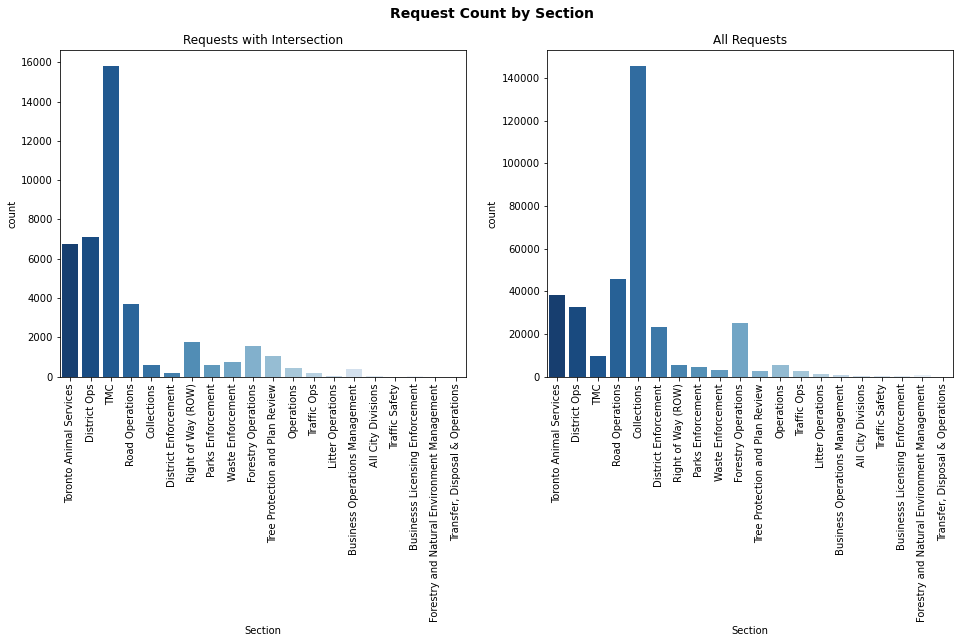

In [48]:
# plot the difference in request count by SECTION between requests with intersection location vs. all requests

fig, ax = plt.subplots(1, 2, sharex=True, figsize=(16,6))
fig.suptitle('Request Count by Section', fontsize=14, weight='bold')

# Intersection Requests
sns.countplot(ax=ax[0], data=requests_2020_intersection, x='Section', palette='Blues_r')
ax[0].set_title('Requests with Intersection')
ax[0].tick_params('x',labelrotation=90)

# All Requests 
sns.countplot(ax=ax[1], data=requests_2020, x='Section', palette='Blues_r')
ax[1].set_title('All Requests')
ax[1].tick_params('x',labelrotation=90)

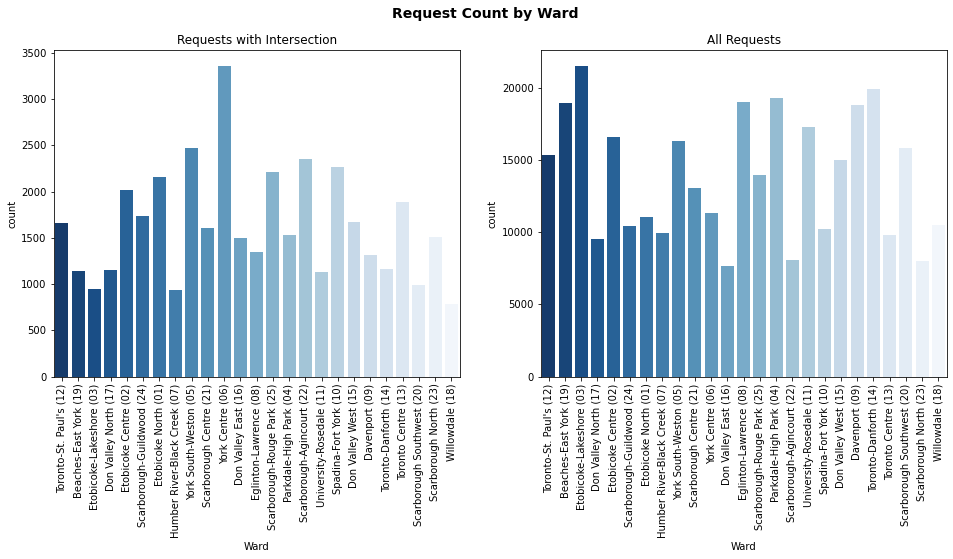

In [49]:
# plot the difference in request count by WARD between requests with intersection location vs. all requests

fig, ax = plt.subplots(1, 2, sharex=True, figsize=(16,6))
fig.suptitle('Request Count by Ward', fontsize=14, weight='bold')

# Intersection Requests
sns.countplot(ax=ax[0], data=requests_2020_intersection, x='Ward', palette='Blues_r')
ax[0].set_title('Requests with Intersection')
ax[0].tick_params('x',labelrotation=90)

# All Requests 
sns.countplot(ax=ax[1], data=requests_2020, x='Ward', palette='Blues_r')
ax[1].set_title('All Requests')
ax[1].tick_params('x',labelrotation=90)

When comparing the request distributions by section and ward, it's clear that the requests with intersection locations do not follow the same general distribution of the overall requests. Unfortunately, we don't have the time to map all the intersection street values to postal codes. Since we know removing the intersection values will skew our data, we will add intersection as a column in our dataset for further consideration, and change their values to NaN in the postal code column:

In [50]:
# engineering new feature called Intersection: if location is intersection based = 1, postal code based = 0
requests_2020['Intersection'] = np.where(requests_2020['First 3 Chars of Postal Code'] == 'Intersection', 1, 0).astype(str)

In [51]:
# in First 3 Chars of Postal Code column, replace all Intersection values with NaN
requests_2020['First 3 Chars of Postal Code'] = requests_2020['First 3 Chars of Postal Code'].replace('Intersection', np.NaN)

In [52]:
# removing the intersection street columns from our data
requests_2020.drop(columns=['Intersection Street 1', 'Intersection Street 2'], inplace=True)

In [53]:
# reviewing our changes 
requests_2020.head(2)

,Status,First 3 Chars of Postal Code,Ward,Service Request Type,Division,Section,Date,Time,Hour,Day of Week,Weekend,Intersection
0,Closed,NaN,Toronto-St. Paul's (12),INJUR/DIST DOMESTIC,Municipal Licensing & Standards,Toronto Animal Services,2020-01-01,00:01:46,0,Wednesday,0,1
1,Closed,M4C,Beaches-East York (19),Sewer Service Line-Blocked,Toronto Water,District Ops,2020-01-01,01:36:56,1,Wednesday,0,0


Let's look more into our postal code values:

In [54]:
requests_2020['First 3 Chars of Postal Code'].unique()

array([nan, 'M4C', 'M9A', 'M6C', 'M8Y', 'M9B', 'M9W', 'M9V', 'M3N', 'M9M',
       'M4E', 'M1J', 'M2H', 'M3H', 'M3A', 'M6E', 'M1X', 'M6M', 'M8W',
       'M4W', 'M6J', 'M5G', 'M4J', 'M4H', 'M9C', 'M8Z', 'M4R', 'M1W',
       'M6H', 'M5M', 'M9L', 'M9N', 'M6K', 'M4K', 'M6G', 'M4S', 'M4B',
       'M4N', 'M5R', 'M5T', 'M3M', 'M6N', 'M5A', 'M1B', 'M5B', 'M6P',
       'M2M', 'M1S', 'M1R', 'M4L', 'M1N', 'M6A', 'M8X', 'M4X', 'M3J',
       'M2J', 'M5N', 'M6S', 'M4M', 'M2R', 'M5S', 'M1E', 'M1H', 'M3L',
       'M5P', 'M3C', 'M1L', 'M2L', 'M3B', 'M4T', 'M1P', 'M4G', 'M1C',
       'M2K', 'M9R', 'M1G', 'M2P', 'M5E', 'M5V', 'M8V', 'M2N', 'M6R',
       'M4P', 'M3K', 'M6B', 'M4Y', 'M1T', 'M1M', 'M4V', 'M1K', 'M5H',
       'M9P', 'M1V', 'M4A', 'M6L', 'M5J', 'M5C', 'M7A', 'M5X', 'M5K',
       'M5L'], dtype=object)

In [55]:
# count of postal codes (not including NaN)
requests_2020['First 3 Chars of Postal Code'].dropna().unique().shape[0]

100

In [56]:
requests_by_FSA = pd.DataFrame(requests_2020.groupby('First 3 Chars of Postal Code').size().sort_values(ascending=False), columns=['Total_Requests'])

In [57]:
requests_by_FSA.head()

,Total_Requests
First 3 Chars of Postal Code,
M6H,7087
M6N,6546
M4L,6408
M6S,6208
M6E,6185


In [58]:
requests_by_FSA.describe()

,Total_Requests
count,100.000000
mean,3069.120000
std,1728.380449
min,2.000000
25%,1750.750000
50%,2955.500000
75%,4088.250000
max,7087.000000


<AxesSubplot:xlabel='First 3 Chars of Postal Code', ylabel='Total_Requests'>

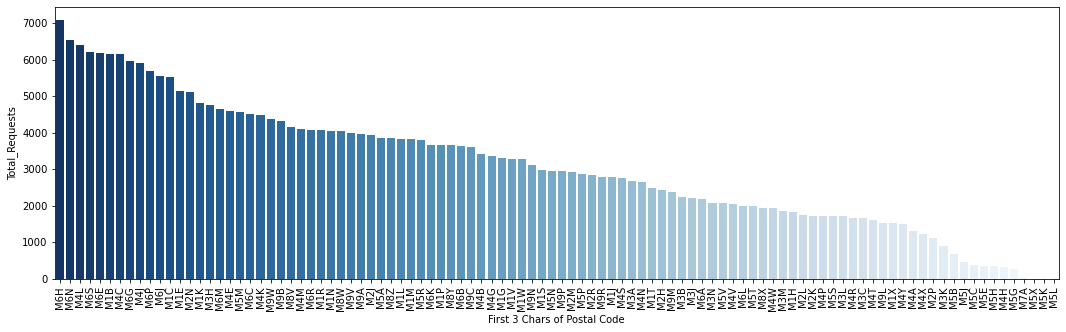

In [59]:
# checking to see if there are any outliers

plt.figure(figsize=(18,5))
plt.xticks(rotation=90)

sns.barplot(data = requests_by_FSA, x=requests_by_FSA.index, y='Total_Requests', palette='Blues_r')

There are 100 unique postal codes in our data. The average amount of requests made by each postal code is 3,069, though the range is quite wide (2 - 7,087), with a standard deviation of 1,728.

#### Wards
Since our postal code data is incomplete, due to the intersection values, we will focus on wards as our main location metric.

Ward names and IDs are currently in one string column, so let's first extract them to be more usable:

In [60]:
# extracting the Ward Name and ID from the Ward Column using regex and str.extract()
requests_2020[['Ward Name', 'Ward ID']] = requests_2020['Ward'].str.extract('(.+)\s\((.\d+)', expand=True)

# dropping Ward column
requests_2020.drop(columns='Ward', inplace=True)

In [61]:
# confirming change
requests_2020.head()

,Status,First 3 Chars of Postal Code,Service Request Type,Division,Section,Date,Time,Hour,Day of Week,Weekend,Intersection,Ward Name,Ward ID
0,Closed,NaN,INJUR/DIST DOMESTIC,Municipal Licensing & Standards,Toronto Animal Services,2020-01-01,00:01:46,0,Wednesday,0,1,Toronto-St. Paul's,12
1,Closed,M4C,Sewer Service Line-Blocked,Toronto Water,District Ops,2020-01-01,01:36:56,1,Wednesday,0,0,Beaches-East York,19
2,Closed,M9A,ENF/INVEST MUZZLE,Municipal Licensing & Standards,Toronto Animal Services,2020-01-01,02:42:16,2,Wednesday,0,0,Etobicoke-Lakeshore,03
3,Closed,M6C,Hydrant-Damage,Toronto Water,District Ops,2020-01-01,02:52:29,2,Wednesday,0,0,Toronto-St. Paul's,12
4,Closed,NaN,Traffic Signal Maintenance,Transportation Services,TMC,2020-01-01,02:56:34,2,Wednesday,0,1,Don Valley North,17


In [62]:
# how many wards are in the dataset?
len(requests_2020['Ward Name'].unique())

25

In [63]:
# how many requests have been made by each ward?
requests_by_ward = pd.DataFrame(requests_2020.groupby(['Ward ID', 'Ward Name']).size().sort_values(ascending=False), columns=['2020 Requests'])

In [64]:
requests_by_ward.reset_index(inplace=True)

In [65]:
requests_by_ward

,Ward ID,Ward Name,2020 Requests
0,03,Etobicoke-Lakeshore,21540
1,14,Toronto-Danforth,19922
2,04,Parkdale-High Park,19281
3,08,Eglinton-Lawrence,19008
4,19,Beaches-East York,18977
5,09,Davenport,18860
6,11,University-Rosedale,17297
7,02,Etobicoke Centre,16636
8,05,York South-Weston,16323
9,20,Scarborough Southwest,15875


<AxesSubplot:xlabel='Ward Name', ylabel='2020 Requests'>

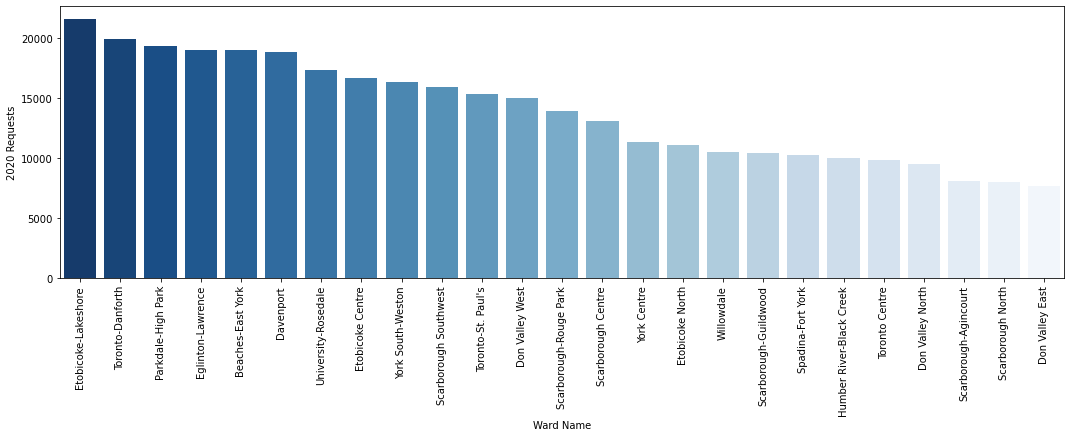

In [66]:
plt.figure(figsize=(18,5))
plt.xticks(rotation=90)

sns.barplot(data = requests_by_ward, x='Ward Name', y='2020 Requests', palette='Blues_r')

The largest volume of 311 service requests comes from the Etobicoke-Lakeshore ward, and the least from Don Valley East. However, this isn't giving us a good picture of each ward's residents, as we haven't factored in each ward's population.

[↑ Back to TOC](#TOC)
## Ward Profiles <a name="wards"></a>
The 2016 Ward Profiles for the 2018 25-Ward model were originally made available from City Planning via the online Toronto Data, Research & Maps portal. The profiles provide demographic, social and economic information for each Ward in the City of Toronto, based on 2016 Census data. The data was provided in a messy table – we have extracted each Ward's population and avg. household income. 

Let's combine our ward profile data for a bit more insight into the amount of service requests placed by Ward. 

In [67]:
ward_profiles.head()

,Ward,Population,Avg. Income per Household
0,1,118040,73374
1,2,118020,128448
2,3,129080,105994
3,4,108805,99784
4,5,116685,67954


In [68]:
# confirming all 25 wards are included
ward_profiles['Ward'].unique().shape[0]

25

In [69]:
# confirming data types are correct
ward_profiles.dtypes

Ward                         int64
Population                   int64
Avg. Income per Household    int64
dtype: object

In [70]:
# reassigning Ward ID to string 
ward_profiles['Ward'] = ward_profiles['Ward'].astype(str)

In [71]:
# add leading zero to wards with single digit values to properly merge with Ward ID column in requests_2020 table
ward_profiles['Ward'] = ward_profiles['Ward'].str.zfill(2)

In [72]:
# merging ward_profiles to requests_by_ward df
requests_by_ward = pd.merge(requests_by_ward, ward_profiles, how='inner', left_on='Ward ID', right_on='Ward')

In [73]:
# dropping repetitive column
requests_by_ward.drop(columns=['Ward'], inplace=True)

In [74]:
requests_by_ward.head()

,Ward ID,Ward Name,2020 Requests,Population,Avg. Income per Household
0,03,Etobicoke-Lakeshore,21540,129080,105994
1,14,Toronto-Danforth,19922,106875,101323
2,04,Parkdale-High Park,19281,108805,99784
3,08,Eglinton-Lawrence,19008,114395,162674
4,19,Beaches-East York,18977,109465,104123


In [75]:
# Engineering new feature = requests per person, rounded to the nearest person (by converting to int)
requests_by_ward['2020 Avg. Requests Per Person'] = (requests_by_ward['2020 Requests'] / requests_by_ward['Avg. Income per Household']*100).astype(int)

In [76]:
requests_by_ward.head()

,Ward ID,Ward Name,2020 Requests,Population,Avg. Income per Household,2020 Avg. Requests Per Person
0,03,Etobicoke-Lakeshore,21540,129080,105994,20
1,14,Toronto-Danforth,19922,106875,101323,19
2,04,Parkdale-High Park,19281,108805,99784,19
3,08,Eglinton-Lawrence,19008,114395,162674,11
4,19,Beaches-East York,18977,109465,104123,18


In [77]:
requests_by_ward.sort_values('2020 Avg. Requests Per Person', ascending=False, inplace=True)

<AxesSubplot:xlabel='Ward Name', ylabel='2020 Avg. Requests Per Person'>

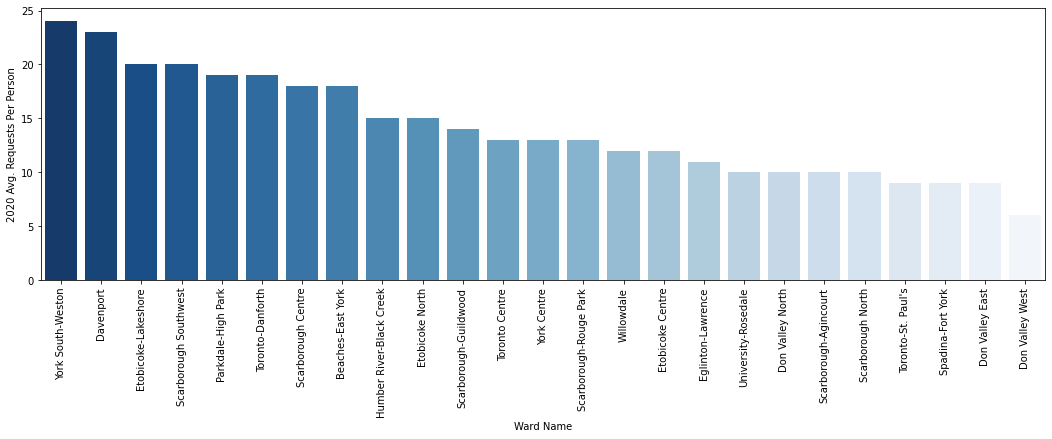

In [78]:
plt.figure(figsize=(18,5))
plt.xticks(rotation=90)

sns.barplot(data = requests_by_ward, x='Ward Name', y='2020 Avg. Requests Per Person', palette='Blues_r')

When we consider ward population, we see that on average, residents in the York South-Weston Ward place the most service requests per person, and residents in the Don Valley West Ward the least.

[↑ Back to TOC](#TOC)
## Weather <a name="weather"></a>
Historical weather information (2020) collected daily from the Toronto International Airport Weather Station. 

In [79]:
weather_2020.head()

,Longitude (x),Latitude (y),Station Name,Climate ID,Date/Time,Year,Month,Day,Data Quality,Max Temp (°C),...,Total Snow (cm),Total Snow Flag,Total Precip (mm),Total Precip Flag,Snow on Grnd (cm),Snow on Grnd Flag,Dir of Max Gust (10s deg),Dir of Max Gust Flag,Spd of Max Gust (km/h),Spd of Max Gust Flag
0,-79.63,43.68,TORONTO INTL A,6158731,2020-01-01,2020,1,1,NaN,-0.2,...,0.0,T,0.0,T,0.0,T,28.0,NaN,42.0,NaN
1,-79.63,43.68,TORONTO INTL A,6158731,2020-01-02,2020,1,2,NaN,6.4,...,0.0,NaN,0.0,NaN,0.0,T,19.0,NaN,46.0,NaN
2,-79.63,43.68,TORONTO INTL A,6158731,2020-01-03,2020,1,3,NaN,6.8,...,0.0,NaN,0.0,NaN,NaN,NaN,27.0,NaN,35.0,NaN
3,-79.63,43.68,TORONTO INTL A,6158731,2020-01-04,2020,1,4,NaN,2.5,...,2.4,NaN,1.6,NaN,2.0,NaN,31.0,NaN,45.0,NaN
4,-79.63,43.68,TORONTO INTL A,6158731,2020-01-05,2020,1,5,NaN,1.3,...,3.6,NaN,3.6,NaN,0.0,T,32.0,NaN,45.0,NaN


In [80]:
weather_2020.columns

Index(['Longitude (x)', 'Latitude (y)', 'Station Name', 'Climate ID',
       'Date/Time', 'Year', 'Month', 'Day', 'Data Quality', 'Max Temp (°C)',
       'Max Temp Flag', 'Min Temp (°C)', 'Min Temp Flag', 'Mean Temp (°C)',
       'Mean Temp Flag', 'Heat Deg Days (°C)', 'Heat Deg Days Flag',
       'Cool Deg Days (°C)', 'Cool Deg Days Flag', 'Total Rain (mm)',
       'Total Rain Flag', 'Total Snow (cm)', 'Total Snow Flag',
       'Total Precip (mm)', 'Total Precip Flag', 'Snow on Grnd (cm)',
       'Snow on Grnd Flag', 'Dir of Max Gust (10s deg)',
       'Dir of Max Gust Flag', 'Spd of Max Gust (km/h)',
       'Spd of Max Gust Flag'],
      dtype='object')

Immediately, we're seeing NaNs that we need to address. For the purposes of our exploration, the only weather columns we are interested in keeping are date/time (for joining), mean temp, total rain, total snow, total precipitation, and spd of max gust – so let's drop all other columns, and see how many NaN values remain. 

In [81]:
weather_2020.drop(columns=[
    'Longitude (x)', 'Latitude (y)', 'Station Name', 'Climate ID', 'Year',
    'Month', 'Day', 'Data Quality', 'Max Temp (°C)', 'Max Temp Flag',
    'Min Temp (°C)', 'Min Temp Flag', 'Mean Temp Flag', 'Heat Deg Days (°C)',
    'Heat Deg Days Flag', 'Cool Deg Days (°C)', 'Cool Deg Days Flag',
    'Total Rain Flag', 'Total Snow Flag', 'Total Precip Flag',
    'Snow on Grnd (cm)', 'Snow on Grnd Flag', 'Dir of Max Gust (10s deg)',
    'Dir of Max Gust Flag', 'Spd of Max Gust Flag'
], inplace=True)

In [82]:
nan_check = weather_2020.isnull().sum()
print(nan_check)

Date/Time                  0
Mean Temp (°C)             0
Total Rain (mm)            7
Total Snow (cm)            7
Total Precip (mm)          0
Spd of Max Gust (km/h)    55
dtype: int64


We've got a reasonable amount of NaNs for Total Rain, Total Snow, and Spd of Max Gust, which shouldn't take long to manually impute. After looking through similar weather datasets from 2020 from other Toronto-based stations, I see that these datasets have more missing values than our current – so I've chosen to instead impute the NaNs by taking an average of the values for the nearest dates above and below each NaN, for each column. 

I will now replace our weather_2020 dataset the updated dataset, and re-drop the unnecessary columns:

In [83]:
weather_2020 = pd.read_csv('en_climate_daily_ON_6158731_2020_P1D_noNaN.csv')

In [84]:
weather_2020.drop(columns=[
    'Longitude (x)', 'Latitude (y)', 'Station Name', 'Climate ID', 'Year',
    'Month', 'Day', 'Data Quality', 'Max Temp (°C)', 'Max Temp Flag',
    'Min Temp (°C)', 'Min Temp Flag', 'Mean Temp Flag', 'Heat Deg Days (°C)',
    'Heat Deg Days Flag', 'Cool Deg Days (°C)', 'Cool Deg Days Flag',
    'Total Rain Flag', 'Total Snow Flag', 'Total Precip Flag',
    'Snow on Grnd (cm)', 'Snow on Grnd Flag', 'Dir of Max Gust (10s deg)',
    'Dir of Max Gust Flag', 'Spd of Max Gust Flag'
], inplace=True)

In [85]:
# confirming that no NaNs remain 
nan_check = weather_2020.isnull().sum()
print(nan_check)

Date/Time                 0
Mean Temp (°C)            0
Total Rain (mm)           0
Total Snow (cm)           0
Total Precip (mm)         0
Spd of Max Gust (km/h)    0
dtype: int64


In [86]:
# reviewing value types
weather_2020.dtypes

Date/Time                  object
Mean Temp (°C)            float64
Total Rain (mm)           float64
Total Snow (cm)           float64
Total Precip (mm)         float64
Spd of Max Gust (km/h)    float64
dtype: object

In [87]:
# correcting weather value (to datetime)
weather_2020['Date/Time'] = pd.to_datetime(weather_2020['Date/Time'])

In [88]:
# checking the values are complete – 2020 was a leap year, so 366 is what we expect
len(weather_2020['Date/Time'].unique())

366

In [89]:
# reviewing basic stats
weather_2020.describe()

,Mean Temp (°C),Total Rain (mm),Total Snow (cm),Total Precip (mm),Spd of Max Gust (km/h)
count,366.000000,366.000000,366.000000,366.000000,366.000000
mean,9.763934,1.672951,0.549180,2.078689,46.323770
std,10.071828,5.082865,2.044582,5.314187,11.032627
min,-14.900000,0.000000,0.000000,0.000000,32.000000
25%,1.600000,0.000000,0.000000,0.000000,39.000000
50%,8.350000,0.000000,0.000000,0.000000,45.000000
75%,19.300000,0.750000,0.000000,1.800000,53.125000
max,28.400000,59.000000,19.400000,59.000000,91.000000


<AxesSubplot:xlabel='Date/Time', ylabel='Mean Temp (°C)'>

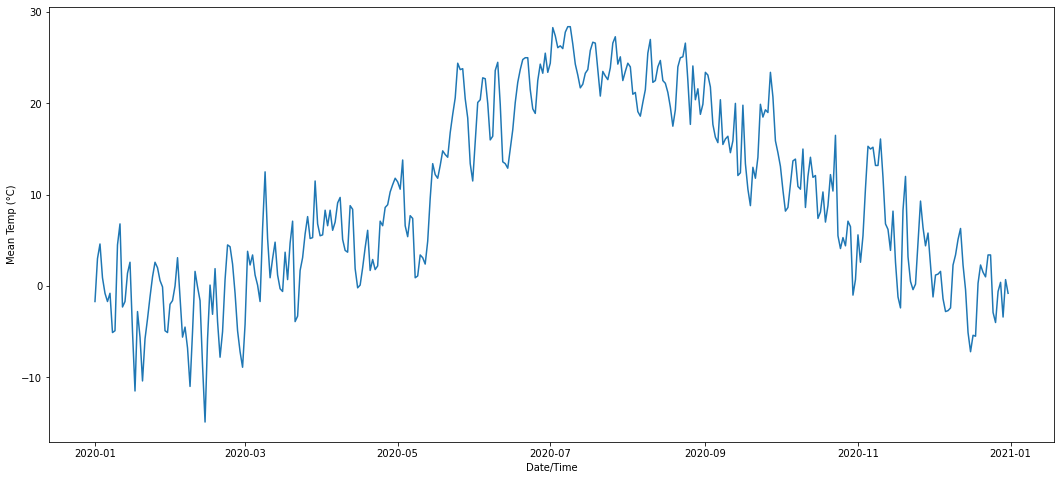

In [90]:
# plotting mean temperature over time
plt.figure(figsize=(18,8))
sns.lineplot(x='Date/Time', y='Mean Temp (°C)', data=weather_2020)

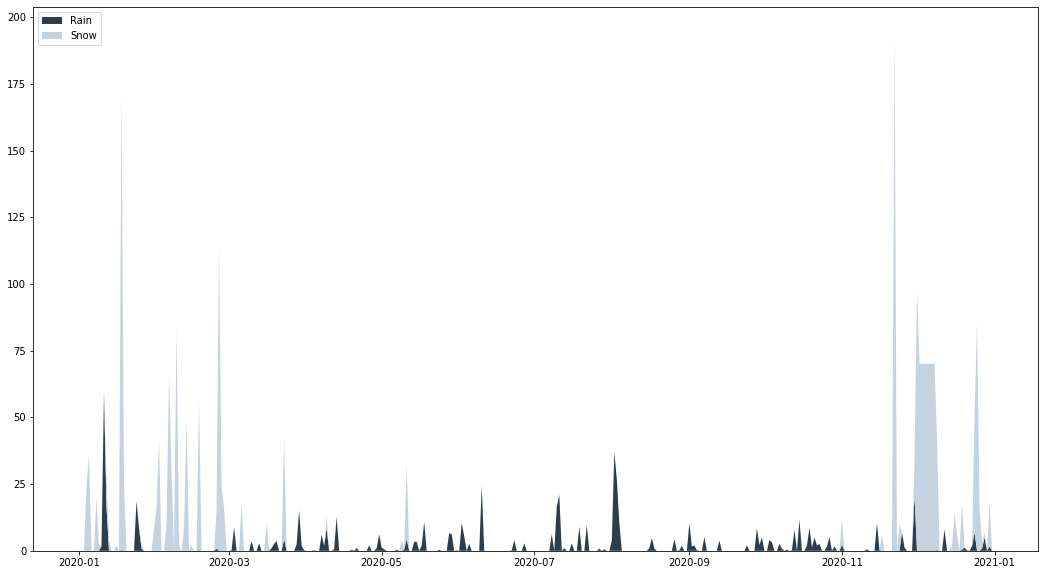

In [91]:
# plotting rain and snow over time
plt.figure(figsize=(18,10))

x  = weather_2020['Date/Time']
y1 = weather_2020['Total Rain (mm)']
y2 = weather_2020['Total Snow (cm)']*10

plt.stackplot(x,y1, y2, labels=['Rain','Snow'], colors=['#2C3E4C', '#C4D3DF'])
plt.legend(loc='upper left')

### Exporting dataframes for use in Tableau

In [92]:
# export cleaned service request df 
# requests_2020.to_csv(r'./tableau/requests_2020.csv')

In [93]:
# export cleaned ward profile df
# requests_by_ward.to_csv(r'./tableau/requests_by_ward.csv')

In [94]:
# export cleaned weather df
# weather_2020.to_csv(r'./tableau/weather_2020.csv')

[↑ Back to TOC](#TOC)
## Classification Modeling: 311 Request Section Prediction <a name="model"></a>

Let's return to our second question: 

<b>Can we predict what a Torontonian is likely to be contacting 311 about based on their location, time of year / day, weather, or other factors?</b>

* [Model Attempt #1](#m1)
* [Model Attempt #2](#m2)

#### Prepping Data
First, we'll merge the usable variables in our existing datasets together:

In [95]:
# reminder of the data in requests_2020
requests_2020.head(1)

,Status,First 3 Chars of Postal Code,Service Request Type,Division,Section,Date,Time,Hour,Day of Week,Weekend,Intersection,Ward Name,Ward ID
0,Closed,NaN,INJUR/DIST DOMESTIC,Municipal Licensing & Standards,Toronto Animal Services,2020-01-01,00:01:46,0,Wednesday,0,1,Toronto-St. Paul's,12


In [96]:
# removing unecessary columns from requests_2020 and saving to model frame
model_frame = requests_2020.drop(columns=['Status', 'Service Request Type', 'Division', 'Time', 'Ward ID']).copy()

In [97]:
model_frame.head(1)

,First 3 Chars of Postal Code,Section,Date,Hour,Day of Week,Weekend,Intersection,Ward Name
0,NaN,Toronto Animal Services,2020-01-01,0,Wednesday,0,1,Toronto-St. Paul's


In [98]:
# merging with weather data
model_frame = pd.merge(model_frame, weather_2020, how='inner', left_on='Date', right_on='Date/Time')

In [99]:
model_frame.head(1)

,First 3 Chars of Postal Code,Section,Date,Hour,Day of Week,Weekend,Intersection,Ward Name,Date/Time,Mean Temp (°C),Total Rain (mm),Total Snow (cm),Total Precip (mm),Spd of Max Gust (km/h)
0,NaN,Toronto Animal Services,2020-01-01,0,Wednesday,0,1,Toronto-St. Paul's,2020-01-01,-1.7,0.0,0.0,0.0,42.0


In [100]:
# extract month and day from 'Date' column
model_frame['Month'] = pd.to_datetime(model_frame['Date']).dt.month.astype(str)
model_frame['Day'] = pd.to_datetime(model_frame['Date']).dt.day.astype(str)

In [101]:
# delete uneccessary columns: 'Date', 'Date/Time'
model_frame.drop(columns=['Date', 'Date/Time'], inplace=True)

In [102]:
model_frame.head()

,First 3 Chars of Postal Code,Section,Hour,Day of Week,Weekend,Intersection,Ward Name,Mean Temp (°C),Total Rain (mm),Total Snow (cm),Total Precip (mm),Spd of Max Gust (km/h),Month,Day
0,NaN,Toronto Animal Services,0,Wednesday,0,1,Toronto-St. Paul's,-1.7,0.0,0.0,0.0,42.0,1,1
1,M4C,District Ops,1,Wednesday,0,0,Beaches-East York,-1.7,0.0,0.0,0.0,42.0,1,1
2,M9A,Toronto Animal Services,2,Wednesday,0,0,Etobicoke-Lakeshore,-1.7,0.0,0.0,0.0,42.0,1,1
3,M6C,District Ops,2,Wednesday,0,0,Toronto-St. Paul's,-1.7,0.0,0.0,0.0,42.0,1,1
4,NaN,TMC,2,Wednesday,0,1,Don Valley North,-1.7,0.0,0.0,0.0,42.0,1,1


In [103]:
# checking that formats are correct 
model_frame.dtypes

First 3 Chars of Postal Code     object
Section                          object
Hour                              int64
Day of Week                      object
Weekend                           int64
Intersection                     object
Ward Name                        object
Mean Temp (°C)                  float64
Total Rain (mm)                 float64
Total Snow (cm)                 float64
Total Precip (mm)               float64
Spd of Max Gust (km/h)          float64
Month                            object
Day                              object
dtype: object

In [104]:
# reassigning incorrect formats
model_frame['Hour'] = model_frame['Hour'].astype(str)
model_frame['Weekend'] = model_frame['Weekend'].astype(str)
model_frame['Intersection'] = model_frame['Intersection'].astype(str)

In [105]:
model_frame.head()

,First 3 Chars of Postal Code,Section,Hour,Day of Week,Weekend,Intersection,Ward Name,Mean Temp (°C),Total Rain (mm),Total Snow (cm),Total Precip (mm),Spd of Max Gust (km/h),Month,Day
0,NaN,Toronto Animal Services,0,Wednesday,0,1,Toronto-St. Paul's,-1.7,0.0,0.0,0.0,42.0,1,1
1,M4C,District Ops,1,Wednesday,0,0,Beaches-East York,-1.7,0.0,0.0,0.0,42.0,1,1
2,M9A,Toronto Animal Services,2,Wednesday,0,0,Etobicoke-Lakeshore,-1.7,0.0,0.0,0.0,42.0,1,1
3,M6C,District Ops,2,Wednesday,0,0,Toronto-St. Paul's,-1.7,0.0,0.0,0.0,42.0,1,1
4,NaN,TMC,2,Wednesday,0,1,Don Valley North,-1.7,0.0,0.0,0.0,42.0,1,1


Since some of our features are strings, we will need to encode them in order to fit our model.

In [106]:
# Separating non-numeric features from model_frame to encode
model_frame_numeric = model_frame[['First 3 Chars of Postal Code', 'Day of Week', 'Ward Name']]
model_frame_numeric

,First 3 Chars of Postal Code,Day of Week,Ward Name
0,NaN,Wednesday,Toronto-St. Paul's
1,M4C,Wednesday,Beaches-East York
2,M9A,Wednesday,Etobicoke-Lakeshore
3,M6C,Wednesday,Toronto-St. Paul's
4,NaN,Wednesday,Don Valley North
...,...,...,...
347743,M9C,Thursday,Etobicoke Centre
347744,M4K,Thursday,Toronto-Danforth
347745,M6S,Thursday,Parkdale-High Park
347746,M1P,Thursday,Scarborough Centre


In [107]:
# Dropping the non numeric from our model_frame
model_frame.drop(columns = ['First 3 Chars of Postal Code', 'Day of Week', 'Ward Name'], inplace=True)

In [108]:
# Using Label Encoding (fit transform) on our non-numeric features
le = preprocessing.LabelEncoder()
model_frame_numeric = model_frame_numeric.apply(LabelEncoder().fit_transform)
model_frame_numeric

,First 3 Chars of Postal Code,Day of Week,Ward Name
0,100,6,20
1,36,6,0
2,90,6,8
3,72,6,20
4,100,6,3
...,...,...,...
347743,92,4,6
347744,41,4,19
347745,83,4,10
347746,10,4,11


In [109]:
# re-combining the model_frame
model_frame_encoded = pd.concat([model_frame, model_frame_numeric], axis=1)
model_frame_encoded.head()

,Section,Hour,Weekend,Intersection,Mean Temp (°C),Total Rain (mm),Total Snow (cm),Total Precip (mm),Spd of Max Gust (km/h),Month,Day,First 3 Chars of Postal Code,Day of Week,Ward Name
0,Toronto Animal Services,0,0,1,-1.7,0.0,0.0,0.0,42.0,1,1,100,6,20
1,District Ops,1,0,0,-1.7,0.0,0.0,0.0,42.0,1,1,36,6,0
2,Toronto Animal Services,2,0,0,-1.7,0.0,0.0,0.0,42.0,1,1,90,6,8
3,District Ops,2,0,0,-1.7,0.0,0.0,0.0,42.0,1,1,72,6,20
4,TMC,2,0,1,-1.7,0.0,0.0,0.0,42.0,1,1,100,6,3


Split into dependent and independent variables:

In [110]:
# define independant variables
X = model_frame_encoded.drop(columns='Section')

# define dependant variables
y = model_frame_encoded['Section']

In [111]:
X.head(2)

,Hour,Weekend,Intersection,Mean Temp (°C),Total Rain (mm),Total Snow (cm),Total Precip (mm),Spd of Max Gust (km/h),Month,Day,First 3 Chars of Postal Code,Day of Week,Ward Name
0,0,0,1,-1.7,0.0,0.0,0.0,42.0,1,1,100,6,20
1,1,0,0,-1.7,0.0,0.0,0.0,42.0,1,1,36,6,0


In [112]:
y

0         Toronto Animal Services
1                    District Ops
2         Toronto Animal Services
3                    District Ops
4                             TMC
                   ...           
347743       District Enforcement
347744       District Enforcement
347745       District Enforcement
347746            Road Operations
347747       District Enforcement
Name: Section, Length: 347748, dtype: object

### [↑](#model) Model Attempt 1 <a name="m1"></a>

Splitting data into a test and train dataset:

In [113]:
# splitting our data into a test and train dataset, test = 20% of data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=222) 

In [114]:
X_train.shape # 80% of data

(278198, 13)

In [115]:
X_test.shape # 20% of data

(69550, 13)

In [116]:
y_train.shape 

(278198,)

In [117]:
y_test.shape

(69550,)

In [118]:
# calling the model 
rf = RandomForestClassifier(n_estimators=12, random_state = 222) 

# fitting the model
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=12, random_state=222)

Creating validation set for hyperparameter tuning

In [119]:
X_train, X2, y_train, y2 = train_test_split(X, y, test_size=0.2, random_state=222)
X_val, X_test, y_val, y_test = train_test_split(X2, y2, test_size=0.5, random_state=222)

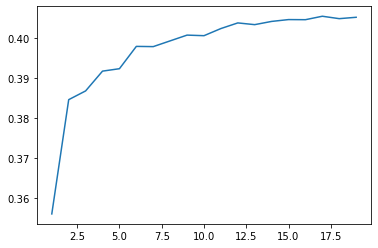

In [120]:
# testing what number of trees is most effective in my model
# 12 appears to be the best number of trees - so we'll update this is in the model call above 
number_of_trees = range(1,20) 
scores = []

for n_trees in number_of_trees:
    rf = RandomForestClassifier(n_estimators=n_trees, random_state=222)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred))
    
plt.plot(number_of_trees, scores)

In [121]:
# finding accuracy on validation set 

y_pred = rf.predict(X_val)

accuracy_score(y_val, y_pred)

0.4134867002156722

Accuracy = 41.3%

In [122]:
print(classification_report(y_val, y_pred))

                                             precision    recall  f1-score   support

                         All City Divisions       0.00      0.00      0.00         6
             Business Operations Management       0.02      0.02      0.02        51
            Businesss Licensing Enforcement       0.33      0.20      0.25         5
                                Collections       0.56      0.67      0.61     14671
                       District Enforcement       0.22      0.18      0.19      2224
                               District Ops       0.23      0.18      0.20      3251
                        Forestry Operations       0.22      0.20      0.21      2466
Forestry and Natural Environment Management       0.12      0.10      0.11        70
                          Litter Operations       0.03      0.03      0.03        97
                                 Operations       0.17      0.12      0.14       562
                          Parks Enforcement       0.18      0.13

<AxesSubplot:title={'center':'Feature Importance'}>

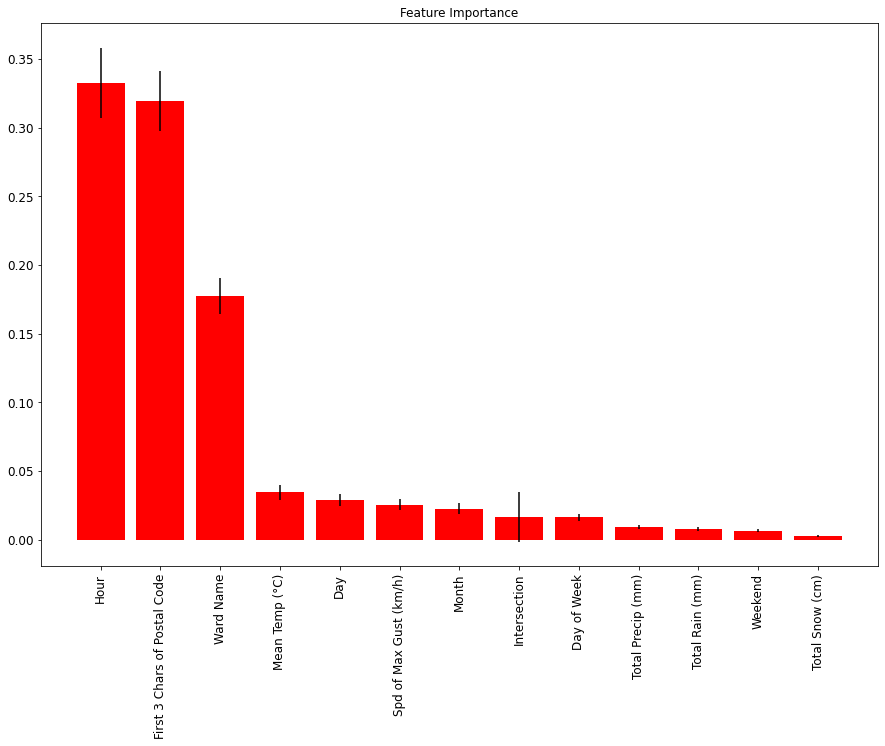

In [123]:
# Over all trees, finding the features that seem to be most important
feature_names = X.columns
skplt.estimators.plot_feature_importances(rf, feature_names = feature_names, figsize=(15,10), x_tick_rotation=90, text_fontsize='large')

Overall, an accuracy of ~40% isn't bad, when you consider that the model is predicting for 20 values. However, when we plot feature importances above, we see that many features overlap one another. Let's try this again by removing some independent variables from our model / reducing noise. 

### [↑](#model) Model Attempt 2 <a name="m2"></a>

First, let's revisit our independent variables and drop features we think may be highly correlated.

In [124]:
X.head()

,Hour,Weekend,Intersection,Mean Temp (°C),Total Rain (mm),Total Snow (cm),Total Precip (mm),Spd of Max Gust (km/h),Month,Day,First 3 Chars of Postal Code,Day of Week,Ward Name
0,0,0,1,-1.7,0.0,0.0,0.0,42.0,1,1,100,6,20
1,1,0,0,-1.7,0.0,0.0,0.0,42.0,1,1,36,6,0
2,2,0,0,-1.7,0.0,0.0,0.0,42.0,1,1,90,6,8
3,2,0,0,-1.7,0.0,0.0,0.0,42.0,1,1,72,6,20
4,2,0,1,-1.7,0.0,0.0,0.0,42.0,1,1,100,6,3


In [125]:
# redefining independent variables
# this time, choosing to drop 'Weekend', 'Day', 'Total Rain (mm)', 'Total Snow (cm)'
X = model_frame_encoded.drop(columns=['Section', 'Weekend', 'Day', 'Total Rain (mm)', 'Total Snow (cm)'])

In [126]:
X.head()

,Hour,Intersection,Mean Temp (°C),Total Precip (mm),Spd of Max Gust (km/h),Month,First 3 Chars of Postal Code,Day of Week,Ward Name
0,0,1,-1.7,0.0,42.0,1,100,6,20
1,1,0,-1.7,0.0,42.0,1,36,6,0
2,2,0,-1.7,0.0,42.0,1,90,6,8
3,2,0,-1.7,0.0,42.0,1,72,6,20
4,2,1,-1.7,0.0,42.0,1,100,6,3


In [127]:
# re-splitting our data into a test and train dataset, test = 20% of data, changing random state
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=444) 

In [128]:
# calling the model 
rf = RandomForestClassifier(n_estimators=12, random_state = 444) 

# fitting the model
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=12, random_state=444)

In [129]:
# re-creating validation set for hyperparameter tuning
X_train, X2, y_train, y2 = train_test_split(X, y, test_size=0.2, random_state=444)
X_val, X_test, y_val, y_test = train_test_split(X2, y2, test_size=0.5, random_state=444)

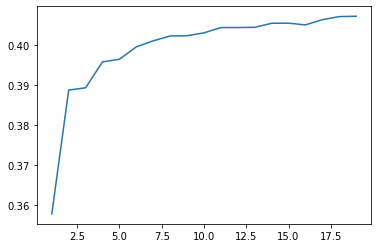

In [130]:
# testing what number of trees is most effective in my model
# 12 appears to be a fine number of trees again - so we'll keep this is in the model call above 
number_of_trees = range(1,20) 
scores = []

for n_trees in number_of_trees:
    rf = RandomForestClassifier(n_estimators=n_trees, random_state=444)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred))
    
plt.plot(number_of_trees, scores)

In [131]:
# finding accuracy

y_pred = rf.predict(X_val)

accuracy_score(y_val, y_pred)

0.4091157440690151

Accuracy = 40.9115%

In [132]:
print(classification_report(y_val, y_pred))

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                             precision    recall  f1-score   support

                         All City Divisions       0.00      0.00      0.00         8
             Business Operations Management       0.00      0.00      0.00        54
            Businesss Licensing Enforcement       0.00      0.00      0.00         6
                                Collections       0.55      0.67      0.61     14553
                       District Enforcement       0.21      0.17      0.19      2295
                               District Ops       0.23      0.18      0.20      3202
                        Forestry Operations       0.23      0.20      0.21      2519
Forestry and Natural Environment Management       0.14      0.11      0.12        72
                          Litter Operations       0.08      0.06      0.07       122
                                 Operations       0.16      0.12      0.14       553
                          Parks Enforcement       0.20      0.12

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot:title={'center':'Feature Importance'}>

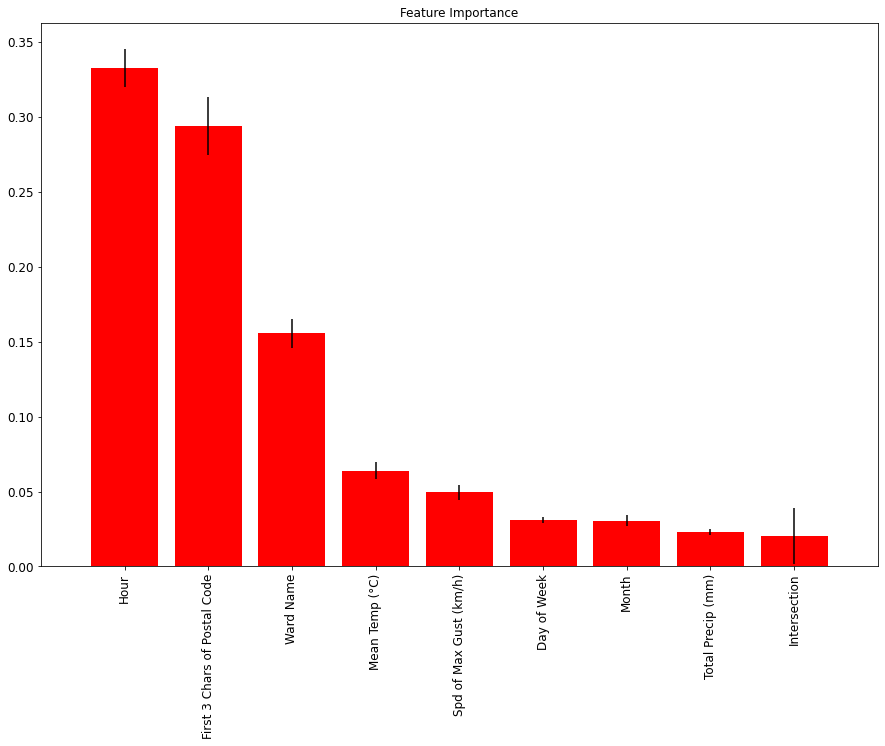

In [133]:
# Over all trees, finding the features that seem to be most important
feature_names = X.columns
skplt.estimators.plot_feature_importances(rf, feature_names = feature_names, figsize=(15,10), x_tick_rotation=90, text_fontsize='large')

Though our second model has a slightly smaller accuracy score when run on our validation dataset (40.9% compared to the previous 41.3%), we have reduced the number of independent variables from 13 to 9, reducing the amount of noise / feature redundancy, so we will keep this second model as our final. Note: we can likely do more with hyper parameter testing - to explore at a later date. 

#### Running the model on our test data – final accuracy score of 40.7%

In [134]:
y_pred = rf.predict(X_test)

accuracy_score(y_test, y_pred)

0.4071315600287563

In [135]:
print(classification_report(y_test, y_pred))

                                             precision    recall  f1-score   support

                         All City Divisions       0.00      0.00      0.00         6
             Business Operations Management       0.00      0.00      0.00        52
            Businesss Licensing Enforcement       0.00      0.00      0.00         4
                                Collections       0.55      0.67      0.61     14502
                       District Enforcement       0.22      0.18      0.19      2346
                               District Ops       0.23      0.19      0.21      3301
                        Forestry Operations       0.23      0.19      0.21      2573
Forestry and Natural Environment Management       0.30      0.19      0.23        75
                          Litter Operations       0.07      0.05      0.06       120
                                 Operations       0.16      0.12      0.13       539
                          Parks Enforcement       0.21      0.14

<AxesSubplot:title={'center':'Feature Importance'}>

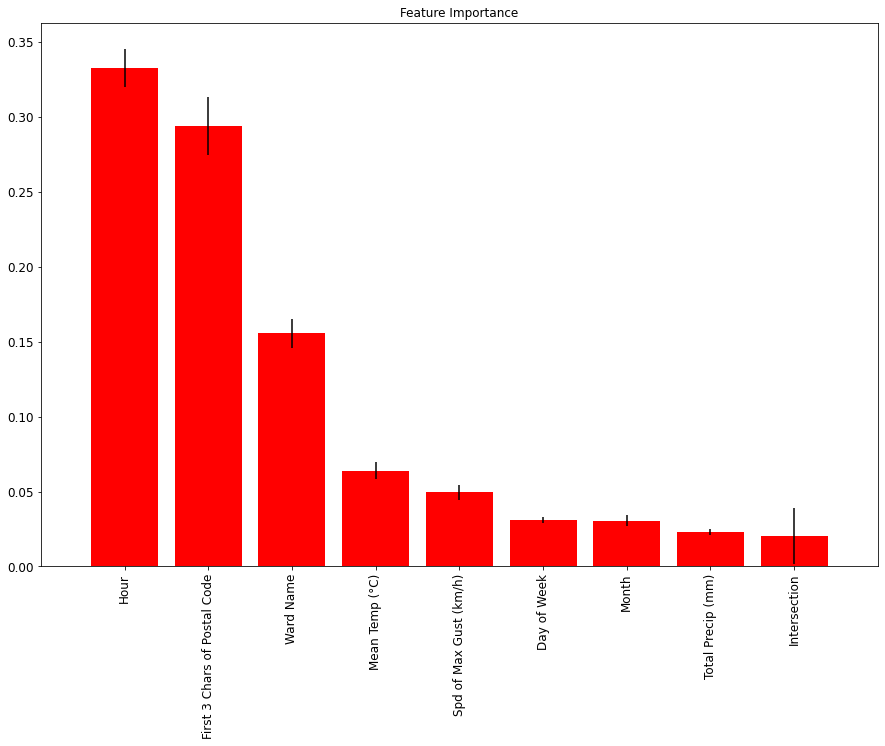

In [136]:
# Over all trees, finding the features that seem to be most important
feature_names = X.columns
skplt.estimators.plot_feature_importances(rf, feature_names = feature_names, figsize=(15,10), x_tick_rotation=90, text_fontsize='large')

In [137]:
# grabbing feature values for visualization elsewhere
importances = np.sort(rf.feature_importances_)
importances

array([0.02042754, 0.02277368, 0.03038662, 0.03104956, 0.04934183,
       0.06391866, 0.15548314, 0.29396513, 0.33265385])

[↑ Back to TOC](#TOC)
## Conclusion <a name="conclusion"></a>
So where does this leave us?

* The Collections Service Division Section is by far the most requested, making up 42% of all requests. (Collections is within the Solid Waste Management Services Division, with most frequent requests being to repair or replace residential bins!)

* Torontonians consistently make far fewer requests on weekends. This could be the result of any number of factors, such as residents being out of town, or otherwise preoccupied with enjoying their lives. 

* The fact that the calls regularly decline around 6pm speaks to the non-urgent nature of 311 calls. Very few calls are placed after 9pm.

* The hour the request was made and the location of the resident are the two largest indicators as to what the request will entail. We hypothesized that temperature would play a greater role in service requests, but weather does not appear to affect the amount of requests significantly, nor were weather factors good indicators of what type of request a Torontonian would be calling in with.

<b>Opportunities for further exploration: </b>

* Residents in higher income areas tended to place less 311 requests overall. This may indicate anything from better maintained neighbourhoods to differences in lifestyle, or neighbourhood infrastructure. 

* There are two noticeable peaks in daily requests by day: January 21st and 22nd, and July 8th and 9th. These peaks (as well as the dip in requests in the spring) are likely impacted by specific external events (e.g. COVID, city-wide happenings, special events) and should be compared against other yearly data. 

<b>Data Limitations: </b>

* We haven't yet considered external impacts (other than weather and income) such as COVID in this analysis. This could be rectified by analyzing more yearly data to find more consistent trends, reviewing the granular event types throughout the year, and gathering more 311 domain knowledge.

* We weren't able to clean the data for the individual request types, so we instead relied on the 311 Integrated Service Division <em> Sections </em> as our request grouping. 

* Missing Data: 
    * The 311 request data did not provide FSA codes for each service request, instead only providing two intersection street names. With time constraints, we were not able to use the streets provided to locate accurate FSAs for each request to complete the FSA data. 
    * The weather data was missing a total of 69 values, which we imputed using the closest available daily averages. 
    
<b>To see this analysis visualized, view the Tableau exploration: 
    https://public.tableau.com/app/profile/meaghan.barry/viz/311_16389979943830/Overview </b>
    
Thanks for reading!